In [63]:
%matplotlib inline

from __future__ import division, print_function

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.special import factorial
from scipy.special import gamma
import time
from scipy import integrate

#Typical plot parameters that make for pretty plots
mpl.rcParams['figure.figsize'] = (8,8)
mpl.rcParams['font.size'] = 30.0

from matplotlib import rc
## for Palatino and other serif fonts use:
rc('font',**{'family':'serif','serif':['Computer Modern']})
rc('text', usetex=True)

### Set the random seed

In [2]:
np.random.seed(int((time.time()%1)*1.0e8))

### Monte Carlo Radiative Transfer

---

Has astrophysical, planetary science, neutron diffusion, and medical physics applications.

In the abscence of scattering and not self-luminous material,
$$
\frac{dI_{\nu}}{dx} = -I_{\nu} \kappa_{\nu}
$$

where $\kappa_{\nu}$ is the volume absorption coefficient.

Reformulate in terms of the optical depth:
$$
\frac{dI_{\nu}}{d \tau_{\nu}} = -I_{\nu}
$$

Solving this gives us Beer's law:
$$
I_{\nu}(x_f) = I_{\nu}(0)e^{-\tau_{\nu}}
$$

Seems easy, but when scattering is included, the situation becomes much more difficult.

---

Single scattering albedo:
$$
= \frac{\kappa_{s}}{\kappa_{s} + \kappa_{a}}
$$
where $\kappa_{s}$ is the volume scattering coefficient and $\kappa_{a}$ is the volume absorption coefficient.

We define
$$
\kappa_{s} = n_s \sigma_s
$$
and
$$
\kappa_{a} = n_a \sigma_a
$$

Next, the phase function $p(\theta, \phi)$ is the probability that the photon will get scattering in the direction $\theta, \phi$ where the total probability must of course be 1.  The angles range from $\theta = 0 - \pi$ and $\phi = 0 - 2\pi$. To show normalization, intgrate $p d\Omega / 4\pi$ over all angles.

For isotropic scattering, we expect $p(\theta, \phi) = 1$ as there is no directional preference.  In princple, probably not true but it's easy.  More realistic scattering is Rayleigh Scattering which goes as
$$
p(\theta, \phi) = \frac{3}{4}(1 + \cos^2 \theta)
$$
but we'll just use simple isotropic scattering.  Also in reality, polarization must be considered.

To solve this, select some $\mu$ uniformly from -1 to 1 (parameterizes $\theta$) and select $\phi$ uniformly from 0 to $2\pi$ at each scattering step.

### Algorithm

```
Schematic:
1) Emit a photon from a source in direction (theta,phi)
2) Photon travels in straight line for some distance and then it interacts with the medium.
3) Use the single-scattering albedo to predict to decide if the photon gets absorbed or scattered.
4) If absorbed, emit another photon and go again

- Loop over number of photons and loop over of number of steps for each photon
```

1) How do we decide how far to travel in a straight line?  Look at the optical depth!

$$
P(\tau)d\tau = e^{-\tau}d\tau
$$

So we sample $\tau$ and use that to get a distance from the integral equation for the optical depth.  To sample this, we'll use the transformation method where we pick

$$
\tau_0 = -ln(1 - U)
$$

where U is a random uniform number between 0 and 1.

To convert this into a physical distance, chunk up the integral so

$$
\tau_0 = \int^x_0 k_{\nu} dx' = \sum_i k_{\nu}(x_i)
$$

where we keep adding pieces until we get $\tau_0$ and hence x.

2) How do we decide to scatter or absorb?
```
if U[rand from 0,1] < single scattering albedo:
    scatter photon
else:
    absorb photon
```

3) How do we decide new direction of photon?

Use the isotropic phase function.

### Plane-parallel atmosphere

```
For some distance traveled s (see above for how to calculate s) and assuming spherical geometry...
1) Sample s, theta, phi

2) Update photon positions
    x = x_old + s * sin(theta) * cos(phi)
    y = y_old + s * sin(theta) * sin(phi)
    z = z_old + s * cos(theta)
  
3) Repeat for steps for photon lifetime, number of photons
```

### Homework 6 Work: 2d random walk along a square lattice.

---

See http://www.mit.edu/~kardar/teaching/projects/chemotaxis(AndreaSchmidt)/random.htm for some simple theory and expectations.

In [47]:
def random_walk_2d(N):
    # For N steps, do a 2d random walk on some lattice in xy space
    
    # Initially start at the origin
    x = 0.0
    y = 0.0
    
    for i in range(0,N):
        
        # Get random numbers for x, y motion
        r = np.random.uniform(0,1)
        
        if(r < 0.25): # Move left
            x = x - 1.0
        elif(r >= 0.25 and r < 0.5): # Move up
            y = y + 1.0
        elif(r >= 0.5 and r < 0.75): # Move right
            x = x + 1.0
        else: # Move down
            y = y - 1.0
        
    # Return squared distance from the origin
    return x**2 + y**2, x, y

In [48]:
def random_walk_2d_ensemble(num, N):
    # Run num random walk runs each of N length
    
    # Allocate arrays to store results of random walk runs
    res = np.zeros(num)
    
    for i in range(0,num):
        res[i] = random_walk_2d(N)[0]
        
    # Return mean, std
    return np.mean(res), np.std(res)

In [49]:
N = np.array([100,1000,10000,100000])
num = 100

means = np.zeros(len(N))
stds = np.zeros(len(N))

for i in range(0,len(N)):
    means[i], stds[i] = random_walk_2d_ensemble(num, N[i])

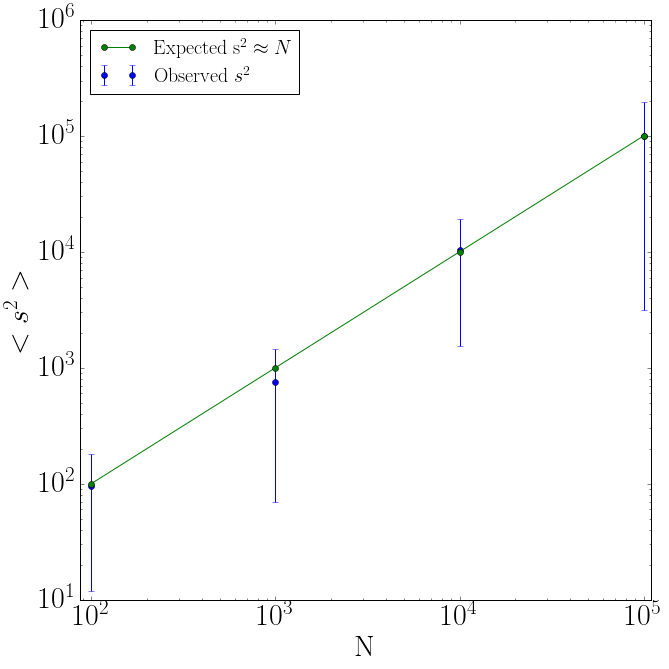

In [65]:
fig, ax = plt.subplots(figsize=(10,10))

# Plot theoretical value
expected = N

ax.errorbar(N,means,yerr=stds,fmt="o",label=r"Observed $s^2$")
ax.plot(N,expected,"o-",label=r"Expected s^2 \approx N")

ax.set_xlabel("N")
ax.set_ylabel(r"$<s^2>$")

ax.set_xlim(N.min()-0.1*N.min(),N.max()+0.1*N.max())
ax.set_xlim(means.min()-0.1*means.min(),means.max()+0.1*means.max())

ax.set_xscale("log")
ax.set_yscale("log")
ax.legend(loc="upper left", fontsize=20)

fig.tight_layout()